In [1]:
# for os-agnostic pathing
from pathlib import Path

# image and plotting stuff
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2

import os
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, find_peaks_cwt, argrelextrema



In [2]:
# path to dataset folder
basepath = "../data/GOALS"

image_path_train = Path(basepath) / "Train" / "Image"
seg_path_train = Path(basepath) / "Train" / "Layer_Masks"
masked_path_train = Path(basepath) / "Train" / "Layer_show"

image_path_validation = Path(basepath) / "Validation" / "Image"
seg_path_validation = Path(basepath) / "Validation" / "Layer_Masks"
masked_path_validation = Path(basepath) / "Validation" / "Layer_show"

image_path_test = Path(basepath) / "Test" / "Image"
seg_path_test = Path(basepath) / "Test" / "Layer_Masks"
masked_path_test = Path(basepath) / "Test" / "Layer_show"

In [3]:
# function to display images
def display_images(
    filenames, 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if len(filenames) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        filenames = filenames[0:max_images]

    images = [Image.open(f) for f in filenames]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
        plt.title(filenames[i])

    plt.show()
        

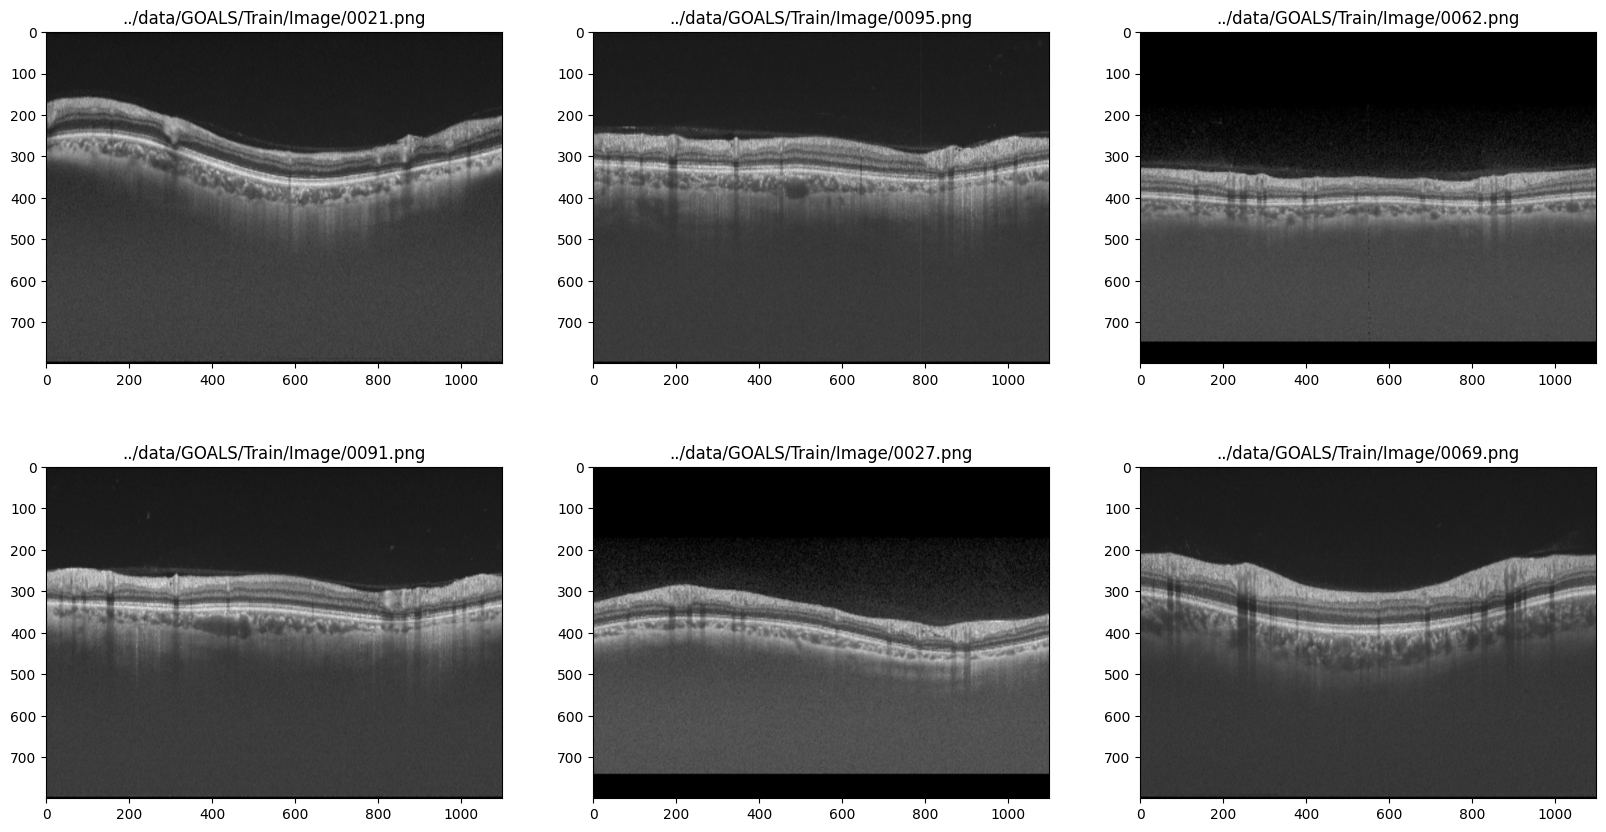

In [4]:
train_imgs = np.random.choice(list(image_path_train.iterdir()), size=6)
display_images(train_imgs, columns=3, max_images=6)

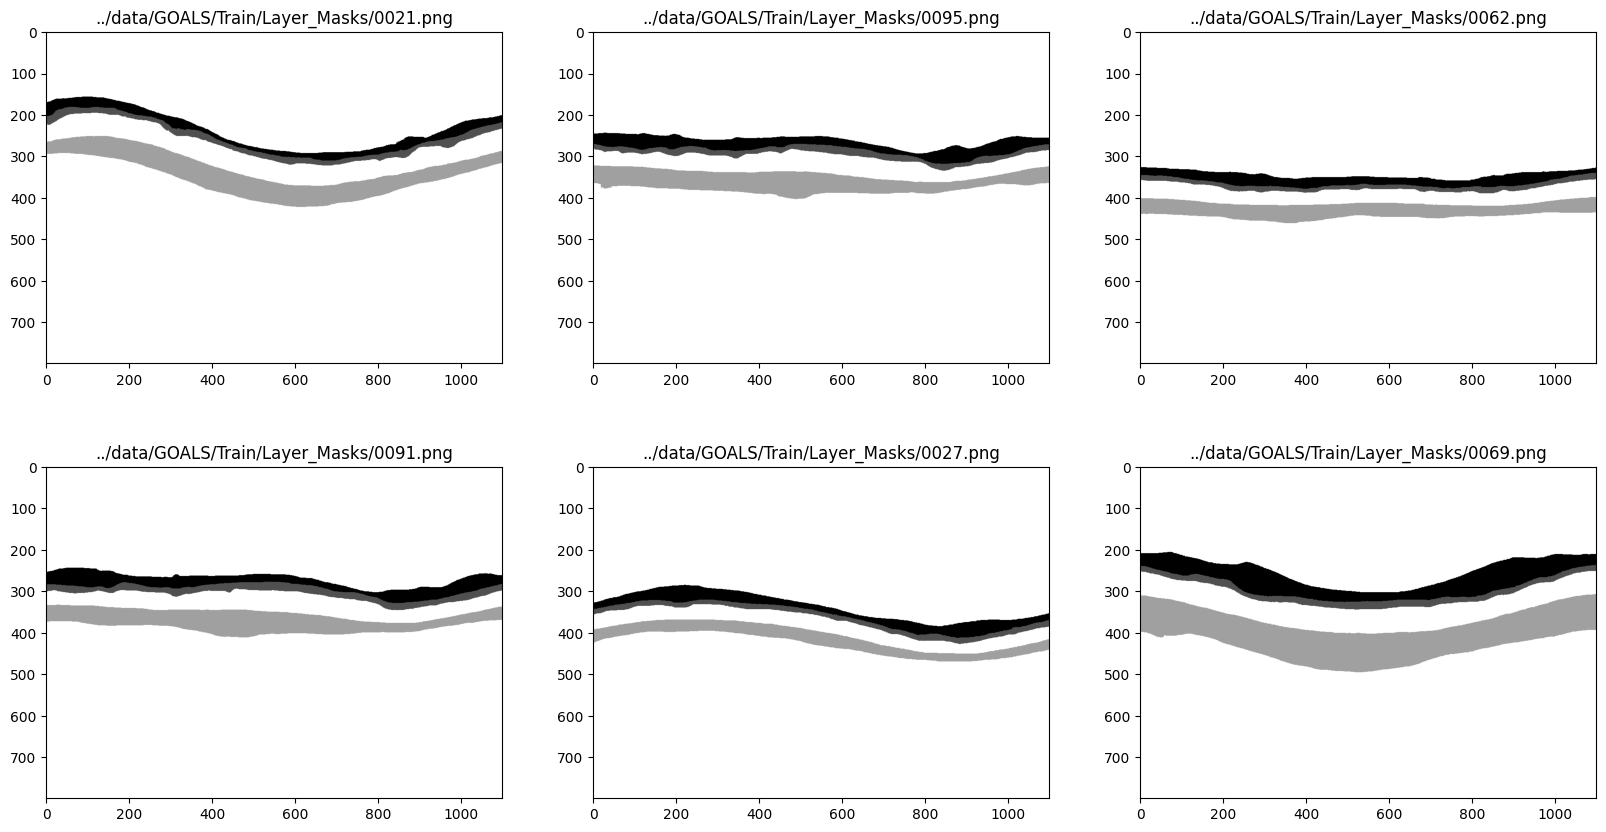

In [5]:
display_images([seg_path_train / Path(name.name) for name in train_imgs], columns=3, max_images=6)

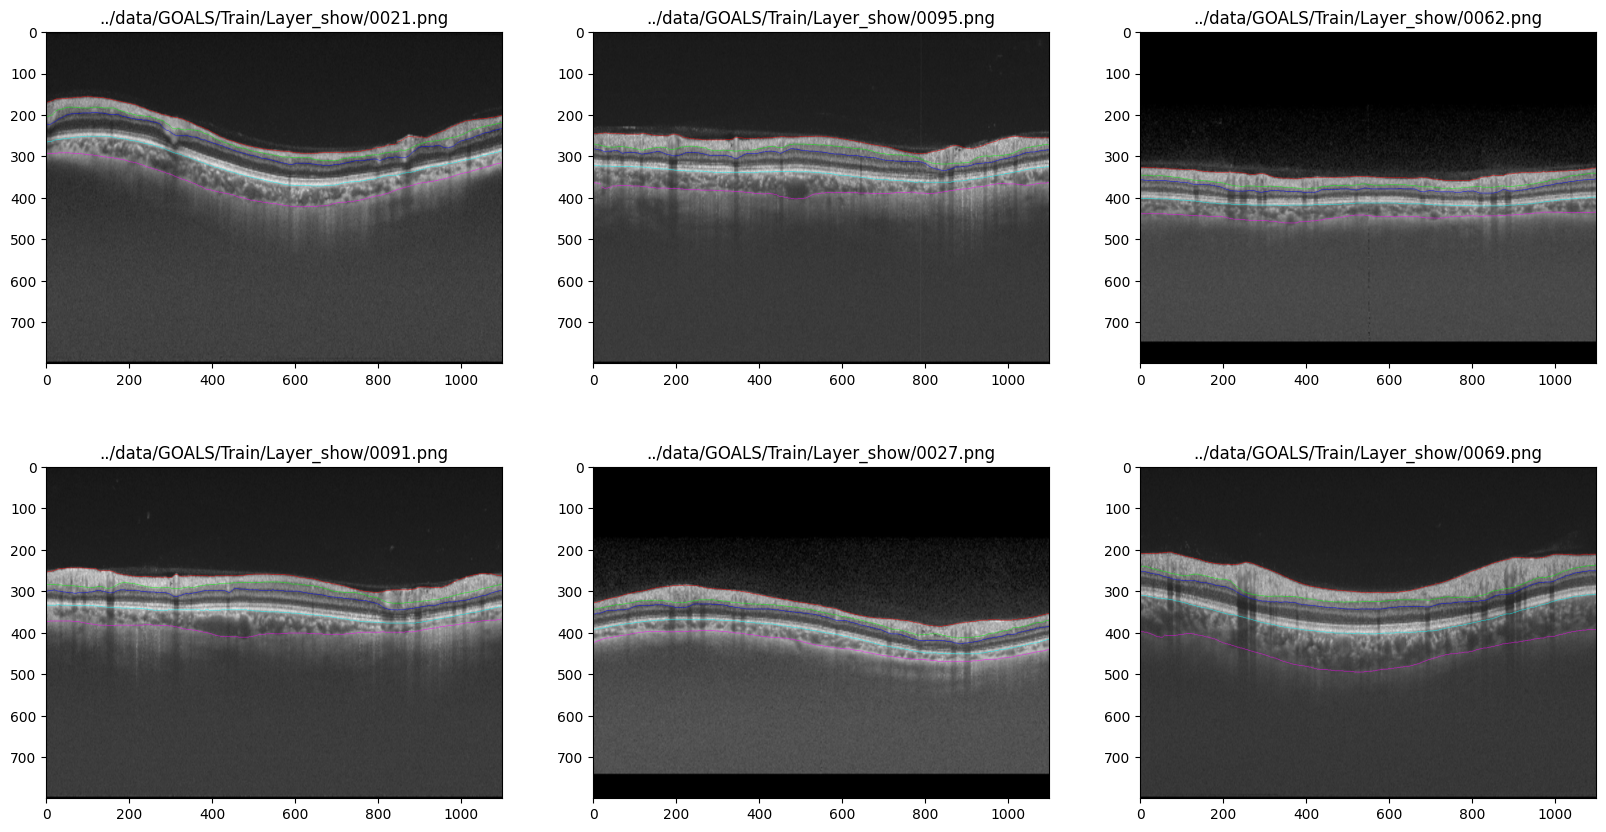

In [6]:
display_images([masked_path_train / Path(name.name) for name in train_imgs], columns=3, max_images=6)

In [7]:
np.random.seed(42)

In [8]:
img_path = np.random.choice(list(image_path_train.iterdir()))
img_path

PosixPath('../data/GOALS/Train/Image/0019.png')

In [9]:
img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
print(img.shape)

(800, 1100)


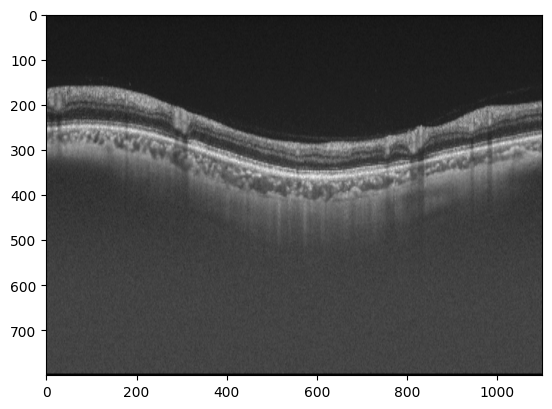

In [10]:
plt.imshow(img, cmap='gray')

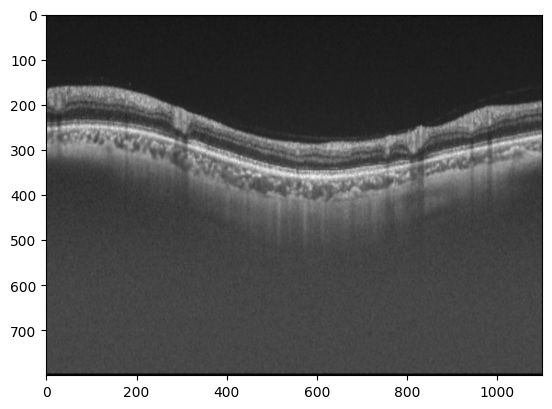

In [11]:
gauss_img = cv2.GaussianBlur(img, (3, 3), 0)
plt.imshow(gauss_img, cmap='gray')

In [12]:
gauss_img.shape

(800, 1100)

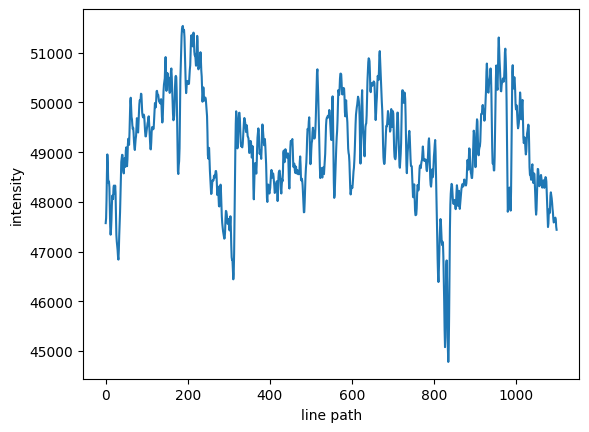

In [13]:
plt.plot(np.sum(gauss_img, axis=0))
plt.ylabel('intensity')
plt.xlabel('line path')
plt.show()

In [14]:
def find_background(img, l_threshold=500, r_threshold=250):
    hor_intensities = np.sum(img, axis=1).astype(np.int32)
    diffs = np.abs(np.diff(hor_intensities[10:-10]))
    l_border = np.argwhere(diffs > l_threshold)[0][0]
    r_border = np.argwhere(diffs > r_threshold)[-1][0]

    return l_border, r_border

In [15]:
hor_intensities = np.sum(gauss_img, axis=1).astype(np.int32)
l_border, r_border = find_background(gauss_img)

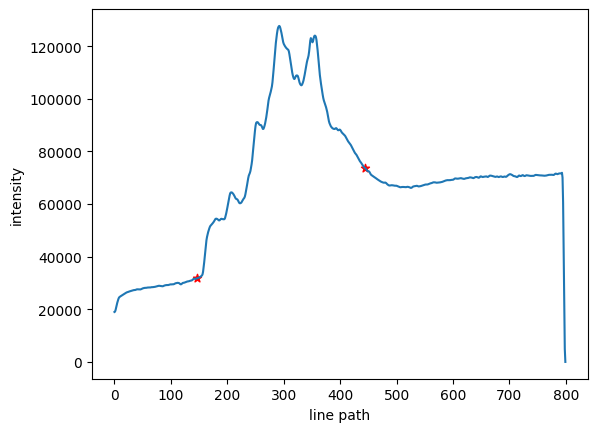

In [16]:
plt.plot(np.sum(gauss_img, axis=1))
plt.scatter([l_border, r_border], hor_intensities[[l_border, r_border]], marker='*', color='red')
plt.ylabel('intensity')
plt.xlabel('line path')
plt.show()

In [125]:
def filter_extrems_by_module(extrems_ind, intensity_profile, eps=50):
    curr = intensity_profile[0]
    filtered_extrems = [extrems_ind[0]]

    for ind in extrems_ind:
        if np.abs(curr - intensity_profile[ind]) > eps:   
            filtered_extrems.append(ind)
        curr = intensity_profile[ind]
    
    return filtered_extrems

In [126]:
l_border, r_border = find_background(gauss_img)

In [127]:
img_slice = gauss_img[:, 50:100]
intensity_profile = np.mean(img_slice, axis=1).astype(np.int32)

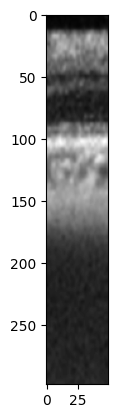

In [128]:
plt.imshow(img_slice[l_border:r_border, :], cmap='gray')

In [129]:
# loc_max = argrelextrema(intensity_profile[l_border:r_border], np.greater, order=7)[0]
# loc_min = argrelextrema(intensity_profile[l_border:r_border], np.less, order=7)[0]

# loc_max = find_peaks(intensity_profile[l_border:r_border], prominence=20)[0] + l_border
# loc_min = find_peaks(-intensity_profile[l_border:r_border], prominence=20)[0] + l_border

# loc_max = find_peaks_cwt(intensity_profile, widths=10)
# loc_min = find_peaks_cwt(-intensity_profile, widths=10)

loc_max = [np.argmax(intensity_profile[l_border:r_border])] + l_border
loc_min = [np.argmin(intensity_profile[l_border:r_border])] + l_border

extrems_ind = np.concatenate((loc_max, loc_min))
extrems_ind.sort()

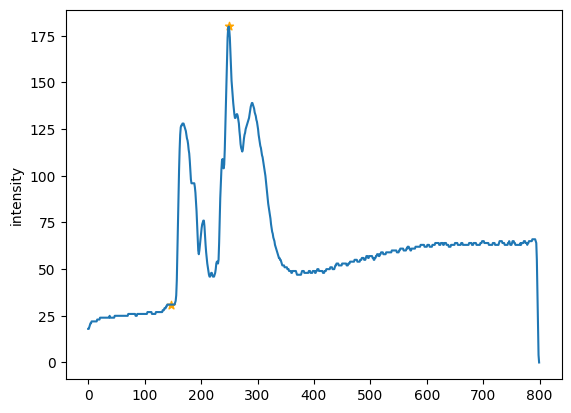

In [130]:
plt.plot(intensity_profile)
plt.scatter(extrems_ind, intensity_profile[extrems_ind], marker='*', color='orange')
plt.ylabel('intensity')
plt.show()

In [131]:
filtered_extrems = filter_extrems_by_module(extrems_ind, intensity_profile, 20)

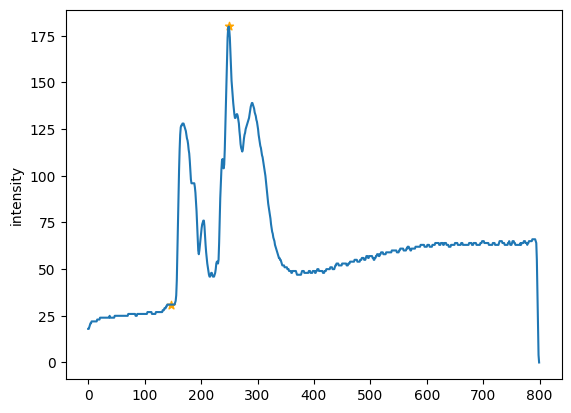

In [134]:
plt.plot(intensity_profile)
# plt.scatter(loc_max, intensity_profile[loc_max], marker='*', color='red')
# plt.scatter(loc_min, intensity_profile[loc_min], marker='*', color='green')
plt.scatter(filtered_extrems, intensity_profile[filtered_extrems], marker='*', color='orange')
plt.ylabel('intensity')
plt.show()

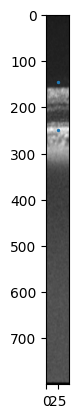

In [135]:
plt.imshow(img_slice, cmap='gray')
plt.scatter(np.repeat(25, len(filtered_extrems)), filtered_extrems, s=2)

In [136]:
slice_size = 50

In [164]:
def get_extrems(intensities, mode='comp', eps=200, prominence=200):
    from scipy.signal import argrelextrema, find_peaks, find_peaks_cwt
    
    if mode == 'comp':
        loc_max = argrelextrema(intensities, np.greater, order=7)[0]
        loc_min = argrelextrema(intensities, np.less, order=7)[0]
    
    if mode == 'peaks':
        loc_max = find_peaks(intensities, distance=70, width=20)[0]
        loc_min = find_peaks(-intensities, distance=70, width=20)[0]

    if mode == 'wavelet':
        loc_max = find_peaks_cwt(intensities, widths=10)
        loc_min = find_peaks_cwt(-intensities, widths=10)

    if mode == 'max':
        loc_max = [np.argmax(intensities)]
        loc_min = [np.argmax(intensities)]

    extrems_ind = np.concatenate((loc_max, loc_min))
    extrems_ind.sort()

    filtered_extrems = filter_extrems_by_module(extrems_ind, intensities, eps)

    return filtered_extrems

In [165]:
def layers_coordinates(img, aggregation='sum', slice_size=50, order=7, mode='comp', eps=200, prominence=200):
    l_border, r_border = find_background(img)

    layers = []
    for ind in range(0, img.shape[1], slice_size):
        # get slice we are interested in
        img_slice = img[l_border:r_border, ind:ind+slice_size]
        # calculate intensity profile
        if aggregation == 'mean':
            intensity_profile = np.mean(img_slice, axis=1).astype(np.int32)
        else:
            intensity_profile = np.sum(img_slice, axis=1).astype(np.int32)
        # find extrems of the function
        extrems = get_extrems(intensity_profile, mode=mode, eps=eps, prominence=prominence) + l_border

        layers.append(np.vstack((np.repeat(ind+slice_size//2, len(extrems)), extrems)))
        
    return layers
        


In [166]:
layers = layers_coordinates(img, aggregation='mean', slice_size=22, mode='max', eps=20)

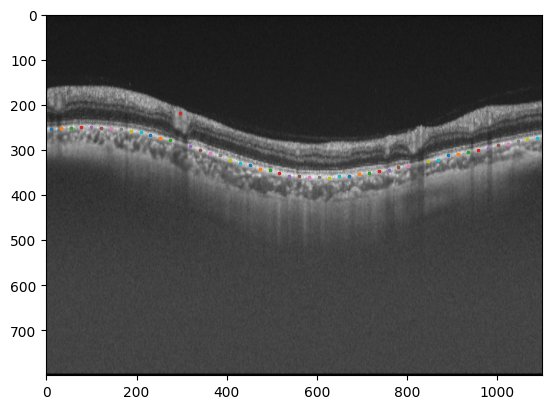

In [167]:
plt.imshow(img, cmap='gray')
for slice_ind in layers:
    plt.scatter(slice_ind[0], slice_ind[1], s=2)
plt.show()

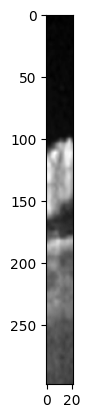

In [172]:
img_slice = gauss_img[l_border:r_border, 37*22:38*22]
plt.imshow(img_slice, cmap='gray')

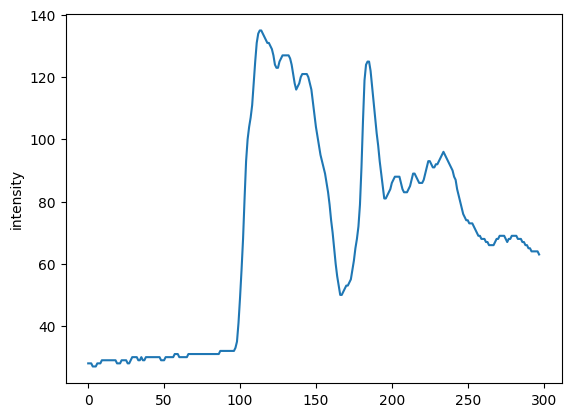

In [173]:
intensity_profile = np.mean(img_slice, axis=1).astype(np.int32)
plt.plot(intensity_profile)
plt.ylabel('intensity')
plt.show()